### Imports

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Inputs

In [114]:
edges_inputs_df = pd.read_csv("../inputs/edges_input.csv")
edges_inputs_label = edges_inputs_df['label'].values

In [115]:
radnet_inputs_df = pd.read_csv("../inputs/radnet_input.csv")
radnet_inputs_label = radnet_inputs_df['label'].values

### Outputs

In [116]:
inference_output_df = pd.read_csv("../outputs/inference_output.csv")
inference_output_class = inference_output_df['class'].values
inference_output_confidence = inference_output_df['confidence'].values

In [117]:
fusion_output_df = pd.read_csv("../outputs/fusion_output.csv")
fusion_output_class = fusion_output_df['class'].values
fusion_output_confidence = fusion_output_df['confidence'].values

In [118]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_class = kalman_output_df['class'].values
kalman_output_confidence = kalman_output_df['confidence'].values

### Confiança: GNN vs Fusão vs Kalman

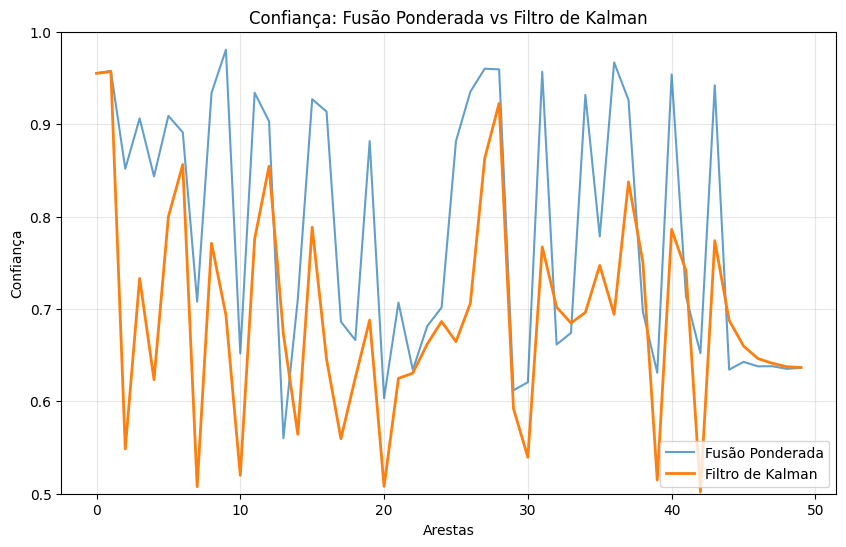

In [119]:
plt.figure(figsize=(10,6))

plt.plot(fusion_output_confidence, label="Fusão Ponderada", alpha=0.7)
plt.plot(kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Confiança: Fusão Ponderada vs Filtro de Kalman")
plt.xlabel("Arestas")
plt.ylabel("Confiança")

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.5, 1)

plt.show()

### 

###